# Jakub's FYP particle tracking script

In this script we will take a video input from our high speed camera and perform particle tracking on it to derive a normalised velocity field.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, util, filters, io, exposure, data
import numpy as np
import pandas as pd
import trackpy as tp
from pandas import DataFrame, Series  # for convenience
from IPython.display import display, HTML
import pims
import os
import cv2
import random
from datetime import datetime

# Define some utility functions that we will use later
def generate_filename(extension):
   time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

   if (extension != ""):
      fname = f"Capture_{time}.{str(extension)}"
      return fname
    
   return f"Capture_{time}"

def is_variable_loaded(name):
    return name in globals()

def save_table_backup(table,name):
    table.to_pickle(os.path.join(WORKING_PATH,'Data',name))

def read_table_backup(name):
    return pd.read_pickle(os.path.join(WORKING_PATH,'Data',name))  
  

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
display(HTML("<style>div.output_scroll { height: max-content; }</style>"))

In [2]:
FOLDER_NAME = "VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)"
WORKING_PATH = 'C:\\Users\\jakub\\Desktop\\graphene\\tests\\Particle tracking'
OUTPUTS_PATH = os.path.join(WORKING_PATH, 'Output files')

IMAGES_PATH =  os.path.join(WORKING_PATH, 'Images', FOLDER_NAME, "*.jpg")
print(IMAGES_PATH)
FRAMES_PER_SECOND = 483.33
FRAME_TIME = 1 / FRAMES_PER_SECOND

C:\Users\jakub\Desktop\graphene\tests\Particle tracking\Images\VideoCapture_10-03-2022_15-36-13 (Attempt 8 - 4g graphite - fresh, 200ml deionised, 0.5ml fairy)\*.jpg


### Load the variables from memory if they have been precalculated earlier

This is handy if you want to carry on working on your dataset after restarting Jupyter Notebook. Those datasets can take a while to calculate, so I thought it would make a lot of sense to back them up to disk and attempt to read them if they're available before recalculating.

In [3]:
# Load variables is available to speed up workflow
if not (is_variable_loaded("f_0")):
    try:
        f = read_table_backup("f_0.pkl")
        print("Loaded f_0.pkl from memory")
    except:
        print("The file f_0.pkl does not exist")

if not (is_variable_loaded("f")):
    try:
        f = read_table_backup("f.pkl")
        print("Loaded f.pkl from memory")
    except:
        print("The file f.pkl does not exist")
        
if not (is_variable_loaded("t")):
    try:
        t = read_table_backup("t.pkl")
        print("Loaded t.pkl from memory")
    except:
        print("The file t.pkl does not exist")
        
if not (is_variable_loaded("t1")):
    try:
        t1 = read_table_backup("t1.pkl")
        print("Loaded t1.pkl from memory")
    except:
        print("The file t1.pkl does not exist")
        
if not (is_variable_loaded("t2")):
    try:
        t2 = read_table_backup("t2.pkl")
        print("Loaded t2.pkl from memory")
    except:
        print("The file t2.pkl does not exist")
        
if not (is_variable_loaded("v_data")):
    try:
        v_data = read_table_backup("v_data.pkl")
        print("Loaded v_data.pkl from memory")
    except:
        print("The file v_data.pkl does not exist")
        
if not (is_variable_loaded("v_data_filtered")):
    try:
        v_data = read_table_backup("v_data_filtered.pkl")
        print("Loaded v_data_filtered.pkl from memory")
    except:
        print("The file v_data_filtered.pkl does not exist")

Loaded f_0.pkl from memory
Loaded t.pkl from memory
Loaded t1.pkl from memory
Loaded t2.pkl from memory
Loaded v_data.pkl from memory
Loaded v_data_filtered.pkl from memory


Frame time: 2.07 ms


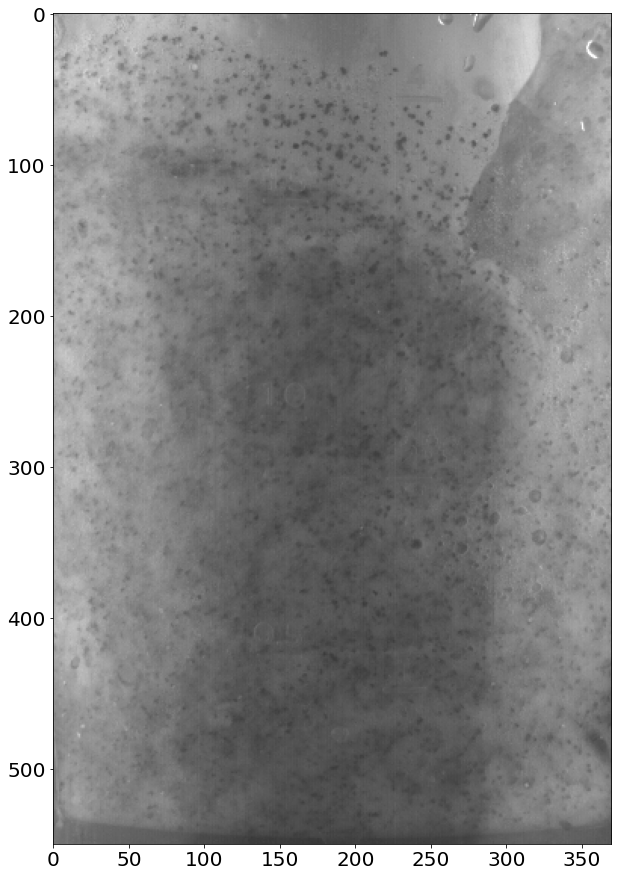

In [267]:
@pims.pipeline
def gray(image):
    return image[:, :, 0]  # Take just the green channel

@pims.pipeline
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 400
    x_max = 770
    y_min = 300
    y_max = 850
    
    return img[y_min:y_max,x_min:x_max]

rawframes = crop(pims.open(IMAGES_PATH))
plt.imshow(rawframes[550]);


print(f"Frame time: {FRAME_TIME*1000:.2f} ms")

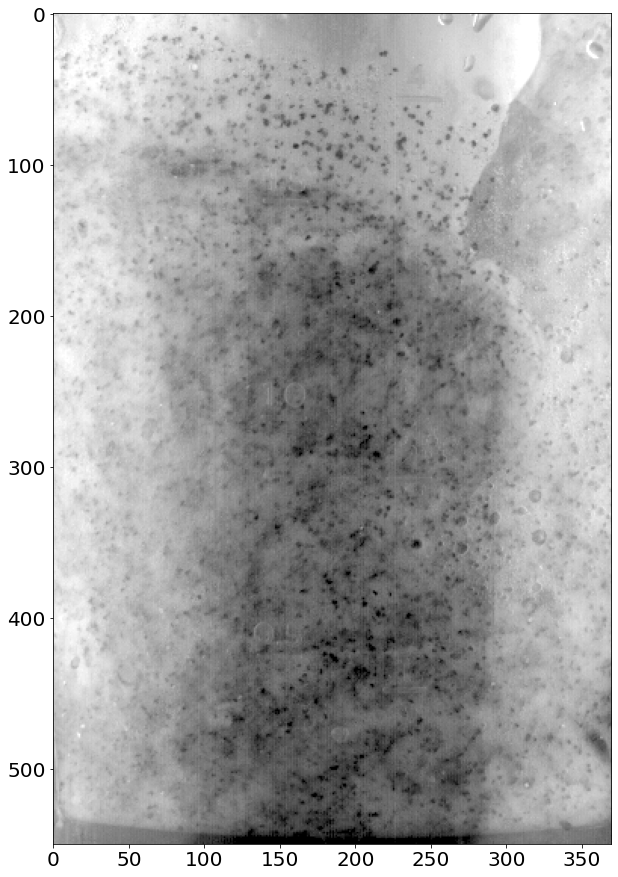

In [266]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    img = gray(crop(img))
    
    percentiles = np.percentile(img, (0.5, 99.5))
    # array([ 1., 28.])
    scaled = exposure.rescale_intensity(img, in_range=tuple(percentiles))
    image_bright = exposure.adjust_gamma(scaled, gamma=0.5,gain=1)

    return util.img_as_int(image_bright)


frames = preprocess_foam(pims.open(os.path.join(IMAGES_PATH)))
plt.imshow(frames[550]);

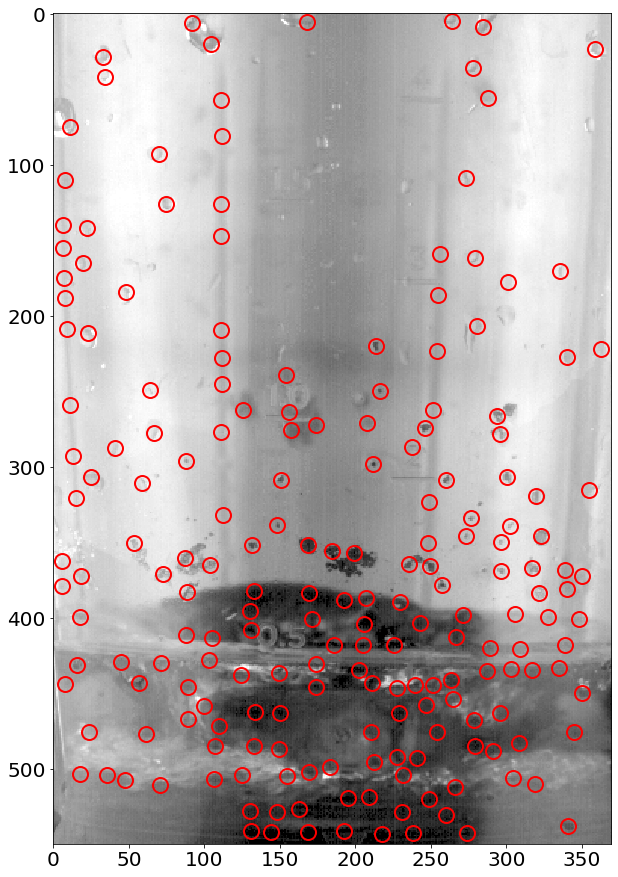

In [265]:
if not (is_variable_loaded("f_0")):
    frame_no = 0
    f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
    save_table_backup(f_0,"f_0.pkl")
    tp.annotate(f_0, frames[frame_no]);
 
frame_no = 0
f_0 = tp.locate(frames[frame_no], 11, invert=True, minmass=35000)
plt.imshow(frames[frame_no])
tp.annotate(f_0, frames[frame_no]);

In [7]:
display(f_0.head(10))
f_0.shape

y           x           mass      size       ecc       signal  \
1    4.443496  263.825568   44813.448925  2.490385  0.249968  2520.855551   
2    5.332119  167.762539   45286.287954  2.555904  0.330877  1986.443527   
3    5.965684   91.985588  130384.323187  2.788211  0.330512  5455.575154   
4    8.644009  284.771886   91938.613061  2.939274  0.439537  3227.256277   
8   19.882568  104.241401  128781.866520  3.082387  0.334747  4406.236231   
9   23.134594  358.595750   52173.110479  2.225722  0.141146  3138.923711   
14  28.691555   32.896138   98312.587100  2.867372  0.282853  3593.316823   
17  35.890491  278.139318   44169.920202  2.599232  0.428782  2462.919780   
20  41.523719   33.948534   37789.191320  2.322893  0.320300  2406.542819   
27  55.673428  287.938136   45263.165606  2.925343  0.233833  1404.227997   

     raw_mass        ep  
1    714943.0  0.473588  
2   1062032.0  0.201546  
3    667405.0  0.580995  
4    734609.0  0.439942  
8    756329.0  0.407934  
9    413744.0 -2.764432  
14   382262.0 -1.612252  
17   639644.0  0.669691  
20   163822.0 -0.414257  
27   666630.0  0.583151

(198, 8)

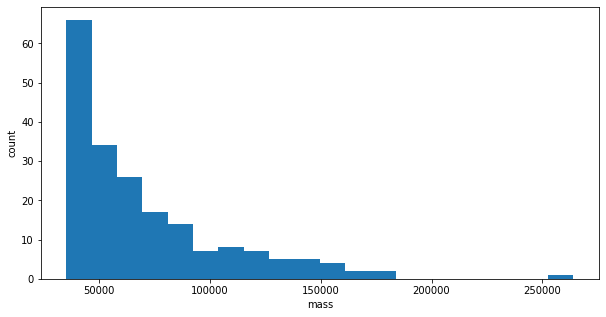

In [8]:
fig, ax = plt.subplots()
ax.hist(f_0['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

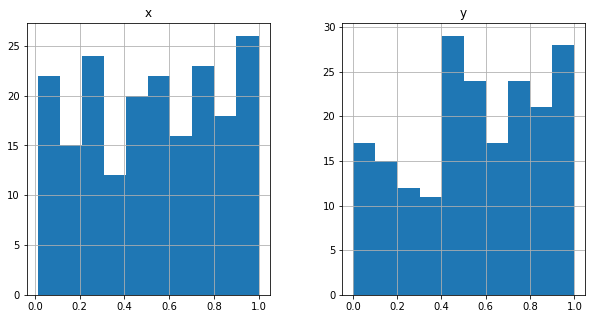

In [9]:
tp.subpx_bias(f_0)

In [10]:
if not(is_variable_loaded("f")):
    f = tp.batch(frames[::], 11, invert=True, minmass=20000);
    save_table_backup(f,'f.pkl')
    display(f.head())

In [11]:
if not(is_variable_loaded("t")):
    t = tp.link(f, 5, memory=3)
    save_table_backup(t,"t.pkl")
    display(t.head())

In [12]:
if not(is_variable_loaded("t1")):
    t1 = tp.filter_stubs(t, 2)
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    save_table_backup(t1, 't1.pkl')
    display(t1.head())

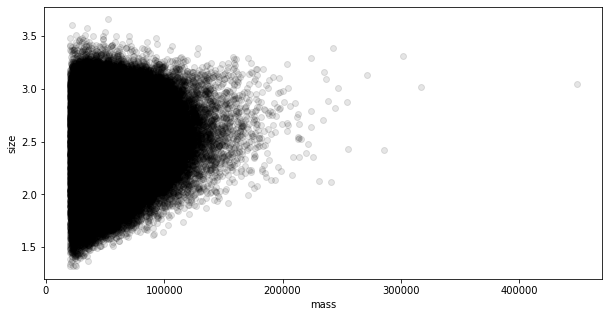

In [13]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [14]:
if not(is_variable_loaded("t2")):
    t2 = t1[((t1['mass'] < 80000) & (t1['size'] < 3.00))]
    save_table_backup(t2, "t2.pkl")
    display(t2.head())

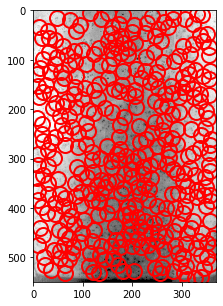

In [15]:
plt.figure()
frame_no=4000
tp.annotate(t2[t2['frame'] == frame_no], frames[frame_no]);

### Calculate the velocity data from the raw tracking results.

Note: this is **extremely** slow, could definitely do with some optimisation. On the full dataset it took a couple of hours (like 3+) to crunch on my laptop.

In [17]:
# Best to read this from the saved file unless you need to recalculate the tracking
if not(is_variable_loaded("v_data")):
    
    v_data = pd.DataFrame()
    for p in set(t2.particle):
        p_data = t2[t2.particle==p]
        dx = np.diff(p_data.x)
        dy = np.diff(p_data.y)
        dt = np.diff(p_data.frame)/FRAMES_PER_SECOND
        v = np.sqrt(dx**2+dy**2)/dt
        vx = dx/dt
        vy = dy/dt

        new_df = pd.concat((p_data.x.reset_index(drop=True), p_data.y.reset_index(drop=True), pd.Series(abs(dx)).rename("dx"), 
                            pd.Series(abs(dy)).rename("dy"), pd.Series(v).rename("v"), pd.Series(vx).rename("vx"),pd.Series(vy).rename("vy"),pd.Series(dt).rename("dt"), p_data.frame.reset_index(drop=True), 
                            p_data.particle.reset_index(drop=True)), axis=1, sort=False)
        v_data = pd.concat((v_data, new_df), axis=0)
    
    save_table_backup(v_data,'v_data.pkl')
    print(v_data['vx'].min(), v_data['vx'].max())
    print(v_data['vy'].min(),v_data['vy'].max())
    display(v_data.head(20))

In [259]:
if not(is_variable_loaded("v_data_filtered")):
    v_data_filtered = v_data[(v_data['y'] > (0)) & ((np.absolute(v_data['v'])) > 400)]
    save_table_backup(v_data_filtered, 'v_data_filtered.pkl')

In [262]:
print(f"There are {len(set(v_data['particle']))} particles to be analysed.")

There are 220266 particles to be analysed.


### Just for fun, we can plot the raw data over a defined period to visualise the chaos

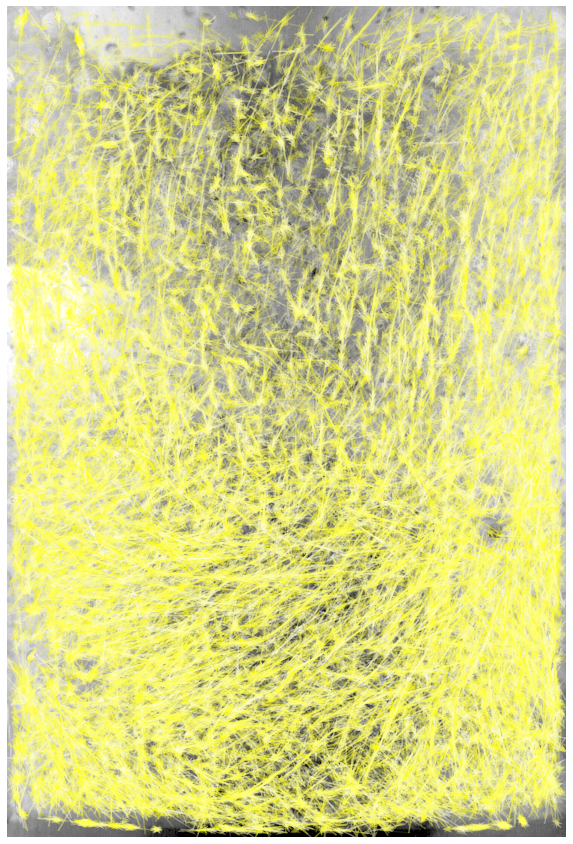

In [263]:
def random_hex(length):
    return ''.join([random.choice('ABCDEF0123456789') for i in range(length)])

scale=2
start_frame = 500
num_frames = 250
start_opacity = 0.1*255
end_opacity = int(255*0.5)
current_opacity = start_opacity
opacity_step = (end_opacity - start_opacity) / (num_frames-1)

px = 1 / plt.rcParams['figure.dpi']
linewidth = 0.4* px / scale

for i in range(start_frame, start_frame + num_frames):
    
    opacity_hex = str(hex(int(current_opacity)))[2:]
    
    random_colour = "#"+"FFFF"+random_hex(2)+opacity_hex
    colour = "#FF0000"+opacity_hex
    
    current_opacity += opacity_step
    d = v_data_filtered[v_data_filtered.frame==i]
    
    plt.imshow(frames[i])
    plt.quiver(d.x, d.y, d.vx, -d.vy, pivot='middle', headwidth=5, headlength=6, color=random_colour, width=linewidth)
    plt.axis('off')
   
# fig = plt.gcf()
# fig.set_size_inches(350*scale*px,524*scale*px)
# plt.savefig(os.path.join(OUTPUTS_PATH,generate_filename("png")),bbox_inches='tight', pad_inches=0)


In [264]:
print(f'The shape of the filtered dataset is {v_data_filtered.shape}')
print(len(set(v_data_filtered['x'])))

The shape of the filtered dataset is (727356, 10)
727356


### Set up the empty point grid

In [250]:
image_size = [frames[0].shape[1], frames[0].shape[0]]
print(image_size)

point_spacing = 10
Ypts = np.arange(0, image_size[1]+point_spacing, point_spacing)
Xpts = np.arange(0, image_size[0]+point_spacing, point_spacing)

max_point_distance = point_spacing / 2

X2D,Y2D = np.meshgrid(Ypts,Xpts)

grid = pd.DataFrame(np.column_stack((Y2D.ravel(),X2D.ravel())),columns=['x','y'])
grid['vx']=np.zeros(shape=(len(grid),1))
grid['vy']=np.zeros(shape=(len(grid),1))
grid['count']=np.zeros(shape=(len(grid),1))

scale = 2
mpl.rc('figure',  figsize=(image_size[0]*scale*px,image_size[1]*scale*px))
fig.set_size_inches(image_size[0]*scale*px,image_size[1]*scale*px)



[370, 550]


### Populate the grid with averaged values from the video

In [258]:
# A rounding function that rounds a number to the nearest given value (5 by default)
def custom_round(x, base=5):
    return int(base * round(float(x)/base))


# Set your analysis range here
start_frame = 0
num_frames = 4000
end_frame = start_frame + num_frames

# Do not modify the original data because it takes hours to recalculate!
grid_input = v_data.copy(deep=True)

# Filter the copied data to only include the chosen frame range
grid_input = grid_input[(grid_input['frame'] > start_frame) & (grid_input['frame'] < end_frame)]

# Round the x and y coordinates of each point to the nearest grid point
grid_input.loc[:,'x'] = grid_input['x'].apply(lambda x: custom_round(x, base=point_spacing))
grid_input.loc[:,'y'] = grid_input['y'].apply(lambda x: custom_round(x, base=point_spacing))

# Function to average the dataset and populate grid values
def populate_grid(input_grid,data_set,mode):
    
    # Do not change the empty template grid
    new_grid = input_grid.copy(deep=True)
    
    for x in set(grid['x']):
        sub_x = data_set[data_set['x'] == x]
        for y in set(sub_x['y']):
            sub_y = sub_x[sub_x['y'] == y]
            
            # Find row in grid table which corresponds to current x and y coords
            idx = new_grid.index[((new_grid['x'] == x) & (new_grid['y'] == y))]
            
            if mode=='mean':
                vx = sub_y['vx'].mean()
                vy = sub_y['vy'].mean()
            elif mode=='median':
                vx = sub_y['vx'].median()
                vy = sub_y['vy'].median()
            else:
                raise Exception("You can only choose mean or median")
                
            new_grid.loc[idx,'vx'] = vx
            new_grid.loc[idx,'vy'] = vy
    
    print(f"Grid populated with {mode} data")
    return new_grid;

mean_grid = populate_grid(grid, grid_input, 'mean')
print(mean_grid['vx'].mean())

median_grid = populate_grid(grid, grid_input, 'median')
print(median_grid['vx'].mean())

Grid populated with mean data
-311.9024544809807
Grid populated with median data
-308.289256948972


### Plot the resultant fields

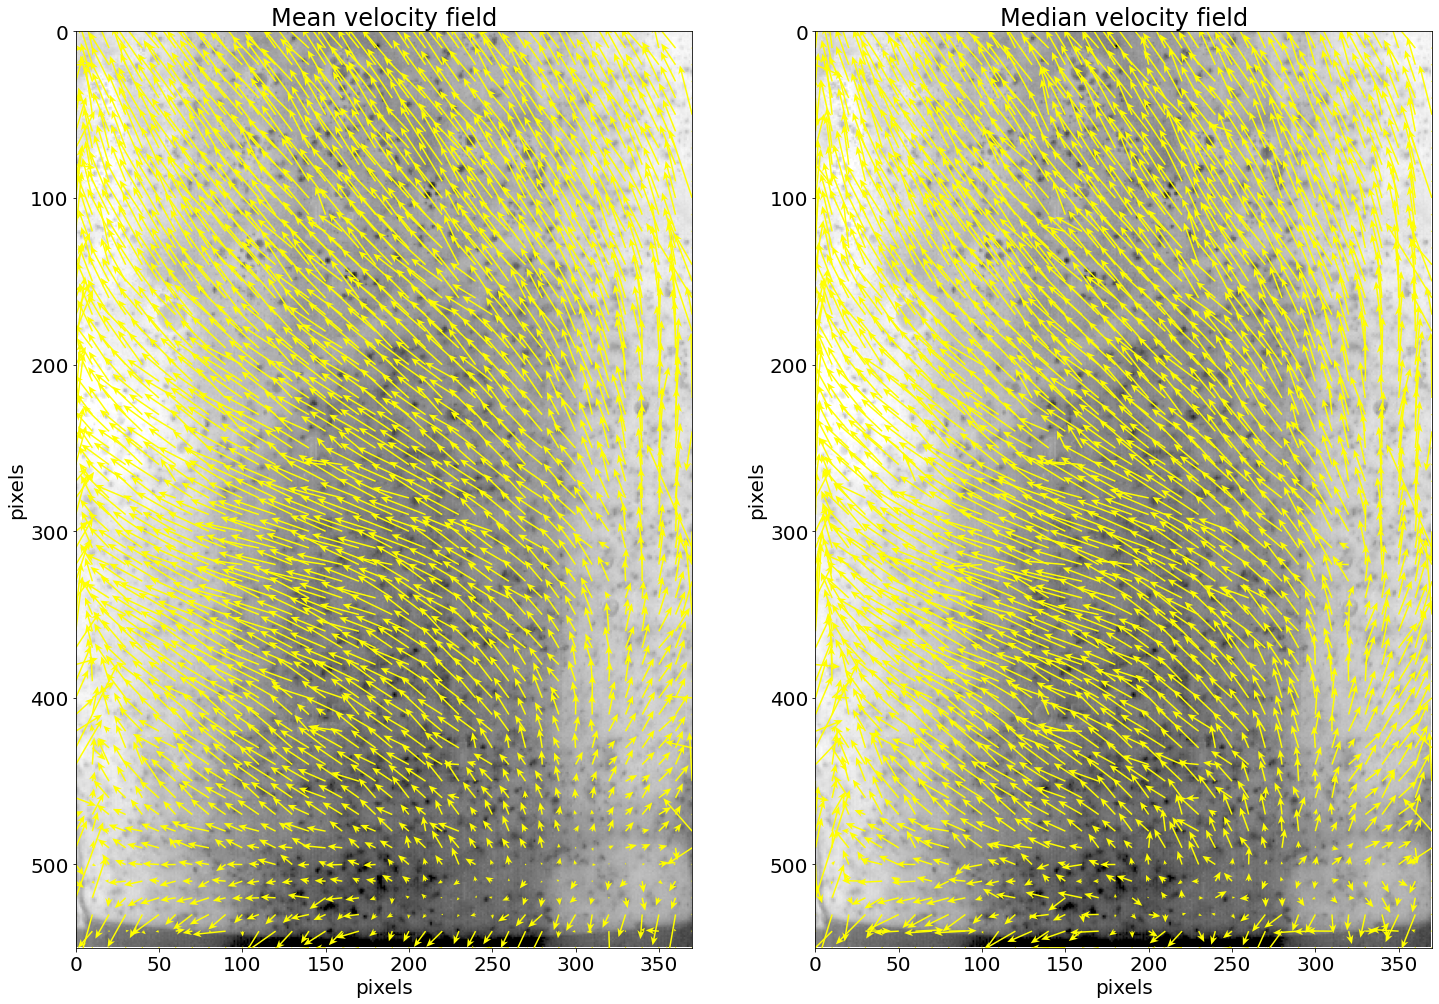

In [268]:
color="#FFFF00"

f, (ax1, ax2) = plt.subplots(1, 2)

px = 1 / plt.rcParams['figure.dpi']
scale = 5
f.set_size_inches(350*scale*px,524*scale*px)
plt.rc('font', size=20) 

ax1.imshow(frames[end_frame])
ax1.quiver(mean_grid['x'],mean_grid['y'],mean_grid['vx'],mean_grid['vy'],  headwidth=5, headlength=6,color=color,scale=10000)
ax1.set_title('Mean velocity field')
ax1.set_xlabel('pixels')
ax1.set_ylabel('pixels')

ax1.set(xlim=(0, image_size[0]), ylim=(image_size[1], 0))

ax2.imshow(frames[end_frame])
ax2.quiver(median_grid['x'],median_grid['y'],median_grid['vx'],median_grid['vy'],  headwidth=5, headlength=6,color=color,scale=10000)
ax2.set_title('Median velocity field')
ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')
ax2.set(xlim=(0, image_size[0]), ylim=(image_size[1], 0))

plt.savefig(os.path.join(OUTPUTS_PATH,generate_filename("jpg")),bbox_inches='tight', pad_inches=0.5)